In [212]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [213]:
import pandas as pd
from functions import main_cleaning

pd.set_option('display.max_columns', None) 

df_raw = pd.read_csv("dielectron.csv")

In [214]:
# both_diff = (((df_raw["Q1"] == -1) & (df_raw["Q2"] == 1) ) | ((df_raw["Q1"] == 1) & (df_raw["Q2"] == -1))).sum()
# both_neg = ((df_raw["Q1"] == -1) & (df_raw["Q2"] == -1)).sum()
# both_pos = ((df_raw["Q1"] == 1) & (df_raw["Q2"] == 1)).sum()

# both_diff, both_neg, both_pos

<Axes: ylabel='M'>

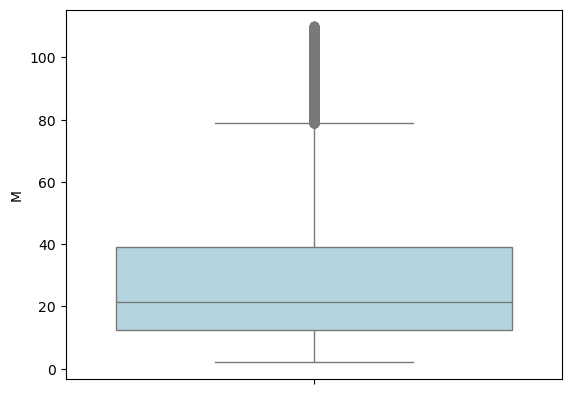

In [215]:
# Outliers
import seaborn as sns
sns.boxplot(data = df_raw["M"], color="lightblue")

In [216]:
df_cleaned = main_cleaning(df_raw)

e:\Iván\Documentos\Clase\Informatica\Beca IronHack\Temario\PROYECTOS\Proyecto_final_1710\functions.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["is_same_charge"] = df["Q1"] == df["Q2"]
e:\Iván\Documentos\Clase\Informatica\Beca IronHack\Temario\PROYECTOS\Proyecto_final_1710\functions.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  #get_lowercase_cols(df)


In [217]:
df_cleaned

,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M,is_same_charge,is_outlier
0,147115,366639895,58.71410,-7.311320,10.531000,-57.29740,12.82020,-2.202670,2.177660,1,11.28360,-1.032340,-1.88066,-11.077800,2.14537,-2.344030,-2.072810,-1,8.94841,False,False
1,147115,366704169,6.61188,-4.152130,-0.579855,-5.11278,4.19242,-1.028420,-3.002840,-1,17.14920,-11.713500,5.04474,11.464700,12.75360,0.808077,2.734920,1,15.89300,False,False
2,147115,367112316,25.54190,-11.480900,2.041680,22.72460,11.66100,1.420480,2.965600,1,15.82030,-1.472800,2.25895,-15.588800,2.69667,-2.455080,2.148570,1,38.38770,True,False
3,147115,366952149,65.39590,7.512140,11.887100,63.86620,14.06190,2.218380,1.007210,1,25.12730,4.087860,2.59641,24.656300,4.84272,2.330210,0.565865,-1,3.72862,False,False
4,147115,366523212,61.45040,2.952840,-14.622700,-59.61210,14.91790,-2.093750,-1.371540,-1,13.88710,-0.277757,-2.42560,-13.670800,2.44145,-2.423700,-1.684810,-1,2.74718,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,146511,522575834,12.31310,-10.658000,5.164440,3.36858,11.84330,0.280727,2.690370,-1,1.80181,0.668609,-1.58437,0.537805,1.71967,0.307851,-1.171470,1,8.44779,False,False
99996,146511,522786431,18.46420,7.854990,15.133000,-7.08659,17.05020,-0.404510,1.092010,1,14.69110,-1.418020,-2.28117,-14.443500,2.68598,-2.383880,-2.126960,1,20.71540,True,False
99997,146511,522906124,4.18566,-3.273500,-0.308507,-2.59013,3.28801,-0.723075,-3.047630,1,72.81740,-11.074900,-9.28179,-71.369300,14.45010,-2.300410,-2.444050,-1,12.71350,False,False
99998,146511,523243830,54.46220,11.352600,11.880900,51.92400,16.43280,1.867800,0.808132,-1,8.58671,0.378009,3.07828,8.007050,3.10141,1.677170,1.448610,1,4.69670,False,False


In [1]:
# df_cleaned["nopordios"] = ((df_cleaned["E1"] + df_cleaned["E2"])**2 - (df_cleaned["px1"]+df_cleaned["px2"])**2 - (df_cleaned["py1"] + df_cleaned["py2"])**2 - (df_cleaned["pz1"] + df_cleaned["pz2"])**2)**0.5

In [219]:
df_cleaned

,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M,is_same_charge,is_outlier
0,147115,366639895,58.71410,-7.311320,10.531000,-57.29740,12.82020,-2.202670,2.177660,1,11.28360,-1.032340,-1.88066,-11.077800,2.14537,-2.344030,-2.072810,-1,8.94841,False,False
1,147115,366704169,6.61188,-4.152130,-0.579855,-5.11278,4.19242,-1.028420,-3.002840,-1,17.14920,-11.713500,5.04474,11.464700,12.75360,0.808077,2.734920,1,15.89300,False,False
2,147115,367112316,25.54190,-11.480900,2.041680,22.72460,11.66100,1.420480,2.965600,1,15.82030,-1.472800,2.25895,-15.588800,2.69667,-2.455080,2.148570,1,38.38770,True,False
3,147115,366952149,65.39590,7.512140,11.887100,63.86620,14.06190,2.218380,1.007210,1,25.12730,4.087860,2.59641,24.656300,4.84272,2.330210,0.565865,-1,3.72862,False,False
4,147115,366523212,61.45040,2.952840,-14.622700,-59.61210,14.91790,-2.093750,-1.371540,-1,13.88710,-0.277757,-2.42560,-13.670800,2.44145,-2.423700,-1.684810,-1,2.74718,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,146511,522575834,12.31310,-10.658000,5.164440,3.36858,11.84330,0.280727,2.690370,-1,1.80181,0.668609,-1.58437,0.537805,1.71967,0.307851,-1.171470,1,8.44779,False,False
99996,146511,522786431,18.46420,7.854990,15.133000,-7.08659,17.05020,-0.404510,1.092010,1,14.69110,-1.418020,-2.28117,-14.443500,2.68598,-2.383880,-2.126960,1,20.71540,True,False
99997,146511,522906124,4.18566,-3.273500,-0.308507,-2.59013,3.28801,-0.723075,-3.047630,1,72.81740,-11.074900,-9.28179,-71.369300,14.45010,-2.300410,-2.444050,-1,12.71350,False,False
99998,146511,523243830,54.46220,11.352600,11.880900,51.92400,16.43280,1.867800,0.808132,-1,8.58671,0.378009,3.07828,8.007050,3.10141,1.677170,1.448610,1,4.69670,False,False


In [220]:
#df_cleaned.to_csv("data/dielectron_cleaned.csv", index=False)

In [221]:
# df_raw["prueba_e1"] = (df_raw["px1"]**2 + df_raw["py1"]**2 + df_raw["pz1"]**2)**(1/2)

In [222]:
# df_raw[df_raw["prueba_e1"].between(df_raw["E1"]*0.9999, df_raw["E1"]*1.0001)]

In [223]:
# df_raw["prueba_e2"] = (df_raw["px2"]**2 + df_raw["py2"]**2 + df_raw["pz2"]**2)**(1/2)

In [224]:
# df_raw[df_raw["prueba_e2"].between(df_raw["E2"]*0.9999, df_raw["E2"]*1.0001)]

In [225]:
df_cleaned.corr()

,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M,is_same_charge,is_outlier
Run,1.000000,0.177576,0.093164,-0.000831,0.002586,-0.008302,0.154408,-0.005291,-0.001459,0.002133,0.099277,0.002781,-0.004945,0.002770,0.151624,0.005260,0.000430,0.002092,0.129529,-0.027551,0.159090
Event,0.177576,1.000000,0.040596,-0.001231,0.001090,-0.003453,0.059091,-0.005430,-0.000470,-0.005648,0.042175,-0.000766,-0.004480,0.002248,0.058889,0.003091,-0.003604,0.003690,0.052378,-0.006966,0.715618
E1,0.093164,0.040596,1.000000,0.006234,0.033984,-0.043042,0.716397,-0.020604,0.020536,0.018578,-0.153895,-0.010189,-0.020155,-0.000507,-0.139262,-0.008527,-0.007137,-0.001131,0.285270,-0.028669,0.026952
px1,-0.000831,-0.001231,0.006234,1.000000,-0.008198,-0.012864,-0.004689,-0.010379,-0.007267,-0.005291,-0.004723,-0.326242,0.001328,-0.004596,-0.003718,-0.003557,0.002468,0.005801,0.006119,-0.000905,-0.000662
py1,0.002586,0.001090,0.033984,-0.008198,1.000000,-0.010301,0.014022,-0.011643,0.593968,-0.002741,0.002012,0.002916,-0.333401,0.000194,0.002570,-0.001637,-0.221726,0.003504,0.007633,0.000859,0.001563
pz1,-0.008302,-0.003453,-0.043042,-0.012864,-0.010301,1.000000,-0.010621,0.771552,-0.011280,-0.002732,0.001849,0.002620,-0.001775,0.205701,0.005739,0.229282,0.003694,0.000417,0.011695,0.001076,-0.001581
pt1,0.154408,0.059091,0.716397,-0.004689,0.014022,-0.010621,1.000000,0.012554,0.005027,0.018397,-0.170058,-0.008246,-0.020120,0.012320,-0.031472,0.004455,-0.006653,-0.003202,0.437208,-0.112420,0.042483
eta1,-0.005291,-0.005430,-0.020604,-0.010379,-0.011643,0.771552,0.012554,1.000000,-0.013329,-0.001762,-0.008856,-0.000828,-0.004048,0.223931,-0.005194,0.245725,0.002130,0.002963,0.017178,0.001803,-0.001812
phi1,-0.001459,-0.000470,0.020536,-0.007267,0.593968,-0.011280,0.005027,-0.013329,1.000000,0.000673,0.001612,0.003182,-0.217188,-0.000025,-0.000749,0.000604,-0.134302,-0.001736,0.001940,0.004588,0.000795
Q1,0.002133,-0.005648,0.018578,-0.005291,-0.002741,-0.002732,0.018397,-0.001762,0.000673,1.000000,-0.011893,-0.003482,0.003441,-0.005311,-0.008545,-0.004503,-0.001611,-0.141169,0.005604,-0.005071,-0.001891
